_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

from IPython.display import Image
from IPython.core.display import HTML

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import missingno as msno


# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
def wrangle(filepath):

  df = pd.read_csv(filepath, parse_dates=['Inspection Date'], index_col='Inspection Date').sort_index()
  filepath = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'

  #Drop Cols
  df.drop(columns=['Violations','Serious Violations Found','Inspection ID', 'State', 'License #'], inplace=True)

  # Drop HCCCs
  cutoff = 500
  drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)


  return df

In [4]:
filepath = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = wrangle(filepath)

In [5]:
df.describe()

,Zip,Latitude,Longitude,Fail
count,51890.000000,51718.000000,51718.000000,51916.000000
mean,60628.834669,41.879568,-87.676663,0.258610
std,22.736963,0.081126,0.059509,0.437875
min,60007.000000,41.644670,-87.914428,0.000000
25%,60614.000000,41.830296,-87.707857,0.000000
50%,60625.000000,41.890166,-87.666524,0.000000
75%,60643.000000,41.939167,-87.634461,1.000000
max,60827.000000,42.021064,-87.525094,1.000000


In [6]:
df.head(10)

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1
2010-01-05,Daycare (2 - 6 Years),Risk 1 (High),CHICAGO,60610.0,License,41.908544,-87.630272,1
2010-01-05,Grocery Store,Risk 2 (Medium),CHICAGO,60623.0,Complaint,41.853573,-87.717254,0
2010-01-05,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Canvass Re-Inspection,41.764896,-87.653965,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60651.0,Complaint,41.901914,-87.773632,0


**Task 1 Test**

In [7]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [8]:
'''T2. Identify data leakage column.'''

# YOUR CODE HERE
leaky_col = "Serious Violations Found"


**Task 2 Test**

In [9]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

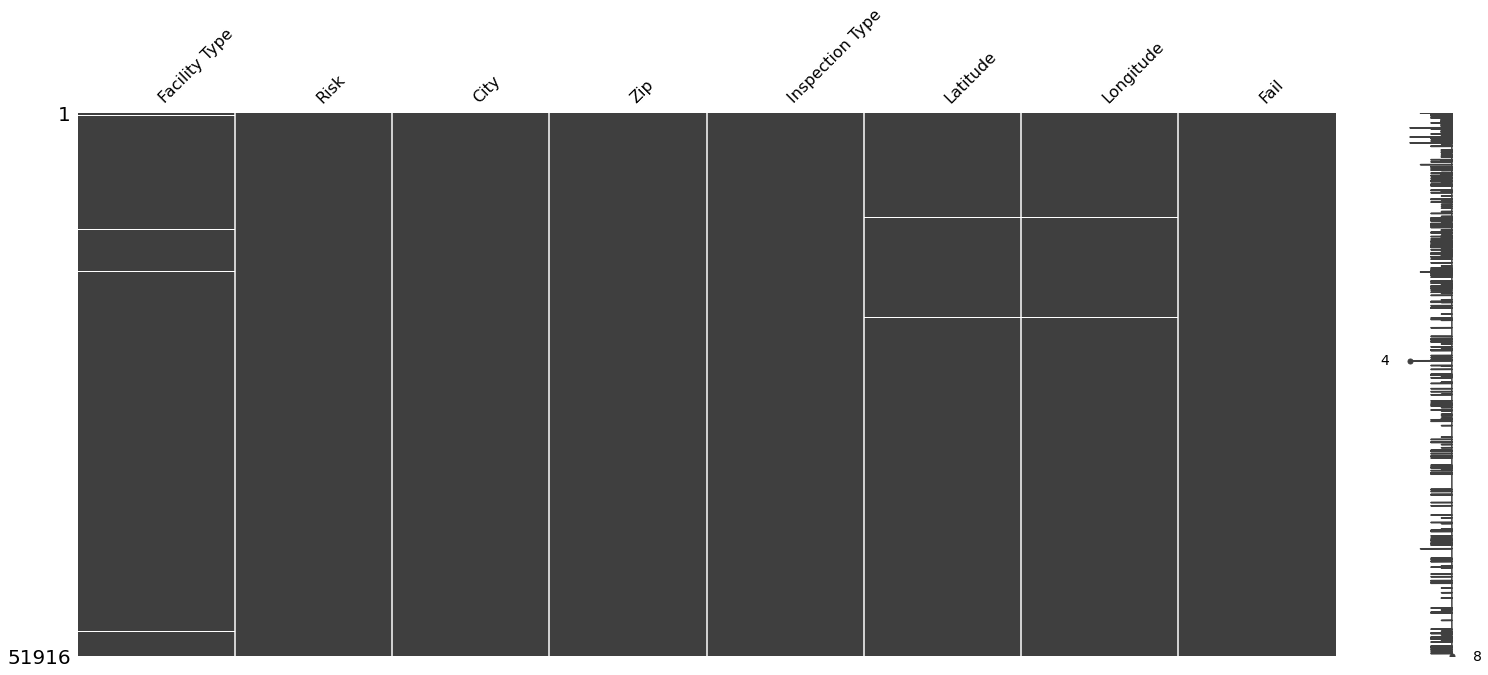

In [10]:
#Refference the wrangle function above :)
msno.matrix(df)
plt.show()

**Task 3 Test**

In [11]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [12]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
y = df[target]
X = df.drop(columns=target)

**Task 4 Test**

In [13]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [14]:
df.head(10)

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60634.0,License Re-Inspection,41.938443,-87.768318,0
2010-01-04,Restaurant,Risk 1 (High),CHICAGO,60613.0,License Re-Inspection,41.961606,-87.675967,0
2010-01-05,Daycare Above and Under 2 Years,Risk 1 (High),CHICAGO,60652.0,License,41.742993,-87.721558,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60666.0,Canvass,42.008536,-87.914428,1
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60639.0,Complaint,41.919224,-87.767734,1
2010-01-05,Daycare (2 - 6 Years),Risk 1 (High),CHICAGO,60610.0,License,41.908544,-87.630272,1
2010-01-05,Grocery Store,Risk 2 (Medium),CHICAGO,60623.0,Complaint,41.853573,-87.717254,0
2010-01-05,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Canvass Re-Inspection,41.764896,-87.653965,0
2010-01-05,Restaurant,Risk 1 (High),CHICAGO,60651.0,Complaint,41.901914,-87.773632,0


In [15]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
cutoff = '2017-01-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

**Task 5 Testing**

In [16]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [17]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE

baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [18]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [19]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=1, n_estimators=75)
)
model_bag.fit(X_train, y_train);

**Tast 7 Testing**

In [20]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [21]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=75)
)
model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [22]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [23]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9077629282520859
Validation accuracy: 0.6811378729309149

Boosting Model
Training accuracy: 0.7544648193750448
Validation accuracy: 0.7035385072851621


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


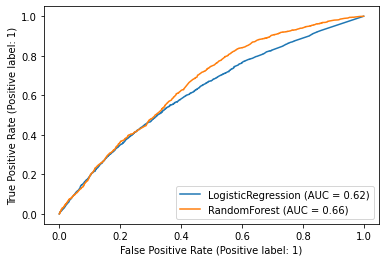

In [24]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
#y_pred_prob = model_boost.predict_proba(X_val)[:, -1]
#fpr, tpr, thresholds = roc_curve(y_val, y_train)

lr = plot_roc_curve(
    model_bag,
    X_val,
    y_val,
    name='LogisticRegression'
)

rf = plot_roc_curve(
    model_boost,
    X_val,
    y_val,
    ax=lr.ax_,
    name='RandomForest'
)

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [25]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE


In [26]:
#BOOST
model_cr = classification_report(y_val,
                                 model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.70      1.00      0.83      7092
           1       0.55      0.01      0.02      2997

    accuracy                           0.70     10089
   macro avg       0.63      0.50      0.42     10089
weighted avg       0.66      0.70      0.59     10089



In [27]:
#BAG
model_cr = classification_report(y_val,
                                 model_bag.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7092
           1       0.44      0.26      0.32      2997

    accuracy                           0.68     10089
   macro avg       0.59      0.56      0.56     10089
weighted avg       0.65      0.68      0.65     10089



**Task 10 Testing**

In [28]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [38]:
df.value_counts()

Facility Type  Risk             City     Zip      Inspection Type        Latitude   Longitude   Fail
Restaurant     Risk 1 (High)    CHICAGO  60666.0  Canvass                42.008536  -87.914428  0       227
               Risk 2 (Medium)  CHICAGO  60666.0  Canvass                42.008536  -87.914428  0       139
               Risk 1 (High)    CHICAGO  60638.0  Canvass                41.789329  -87.741646  0        75
                                         60666.0  Canvass Re-Inspection  42.008536  -87.914428  0        72
                                                  Canvass                42.008536  -87.914428  1        60
                                                                                                       ... 
                                         60610.0  Canvass Re-Inspection  41.909030  -87.634497  0         1
                                                                         41.908978  -87.634789  0         1
                                   

In [48]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE


'T11. Create DataFrame of permutation importances.'

In [50]:
# Step 1: Choose feature (column)
column_to_permute = 'Risk'

In [64]:
#Step 2: Train model w/ ALL features
model_to_permute = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1)
)
model_to_permute.fit(X_train, y_train);

In [65]:
#Step 3: Evaluate model using Validation data
print('Validation Accuracy', model_to_permute.score(X_val, y_val))

Validation Accuracy 0.7033402715829121


In [71]:
#Step 4: In VALIDATION DATA, permute the feature we're evaluating
X_val_perm = X_val.copy()
X_val_perm[column_to_permute] = np.random.permutation(X_val_perm[column_to_permute])

In [72]:
#Step 5: Calculate our error metric with permuted data
print('Validation Accuracy', model_to_permute.score(X_val_perm, y_val))

Validation Accuracy 0.703934978689662


In [73]:
# Automated using sklearn

perm_imp = permutation_importance(model_to_permute, X_val, y_val, random_state=42)

In [74]:
perm_imp

{'importances_mean': array([5.35236396e-04, 4.95589256e-04, 0.00000000e+00, 3.17177124e-04,
        7.73119239e-04, 4.95589256e-04, 7.92942809e-05]),
 'importances_std': array([0.00022252, 0.00028035, 0.        , 0.00053707, 0.00032814,
        0.00042517, 0.00052223]),
 'importances': array([[ 0.00049559,  0.00019824,  0.00049559,  0.00059471,  0.00089206],
        [ 0.00079294,  0.00059471,  0.00039647,  0.00069382,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00049559,  0.00059471,  0.        ,  0.0010903 ,  0.00039647],
        [ 0.00089206,  0.00019824,  0.00069382,  0.00089206,  0.00118941],
        [ 0.00079294, -0.00029735,  0.00079294,  0.00079294,  0.00039647],
        [ 0.00029735, -0.00019824, -0.00049559, -0.00019824,  0.00099118]])}

In [75]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
permutation_importances = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [76]:
permutation_importances

,imp_mean,imp_std
City,0.000000,0.000000
Longitude,0.000079,0.000522
Zip,0.000317,0.000537
Risk,0.000496,0.000280
Latitude,0.000496,0.000425
Facility Type,0.000535,0.000223
Inspection Type,0.000773,0.000328


**Task 11 Testing**

In [77]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

In [79]:
permutation_importances.shape

(7, 2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

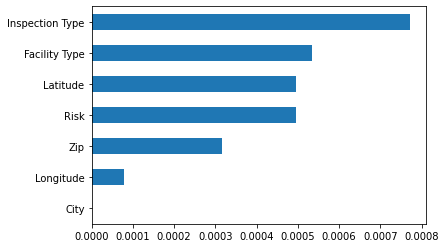

In [87]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
permutation_importances['imp_mean'].tail(10).plot(kind='barh')

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.